# Facial_Mood_Recognition

In this project, I designed a CNN to recognize people moods from their face images. I used data augmentation as the dataset did not contain that much items. Model evaluation and learning curves represent good predictability of the model.

The dataset is downloaded from:
[dataset link](https://github.com/spenceryee/CS229/tree/master)

(The following code is however mine)

### By: ZaraPhCode

Importing necessary modules:

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import random
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Load, visualize and preprocessing the dataset

The data are at folder <code>dataset2</code>. Data associated with each class are in similar subfolders.

Lets see the number of pictures in folder <code>happiness</code>:

In [33]:
len(os.listdir('dataset2/happiness'))

81

Lets see one of the data in folder <code>happiness</code>:

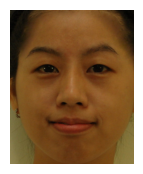

In [8]:
img = mpimg.imread('dataset2/happiness/f01_dfs_h.jpg')
plt.figure(figsize=(2,2))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

We are going to need the dimension of images for training:

In [34]:
img.shape

(600, 480, 3)

This image size is relatively large. We do not need that much detail. So I reduced the image size by dividing their length and width by 3.

We can now determine model parameters and building the train and validation datasets:

In [10]:
h = 200
w = 160
image_size = (h,w)
batch_size = 64
dataset_folder = 'dataset2'

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_folder,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 619 files belonging to 8 classes.


Using 496 files for training.
Using 123 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [11]:
class_names = train_ds.class_names
print(class_names)

['anger', 'contempt', 'disguest', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


Lets plot some instances from our dataset:

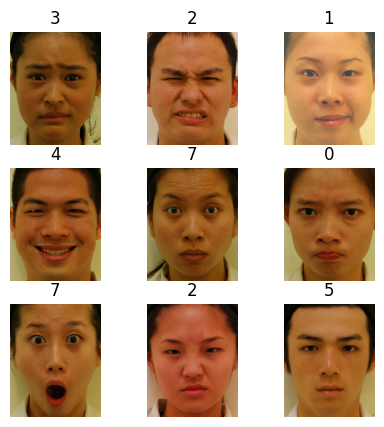

In [12]:
plt.figure(figsize=(5,5))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

The `image_batch` is a tensor of the shape `(64,200,160, 3)`. This is a batch of 32 images of shape `200,160x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(64,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 200, 160, 3)
(64,)


As our dataset does not contain large amount of data, lets do some data augmentation:

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(h,
                                  w,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

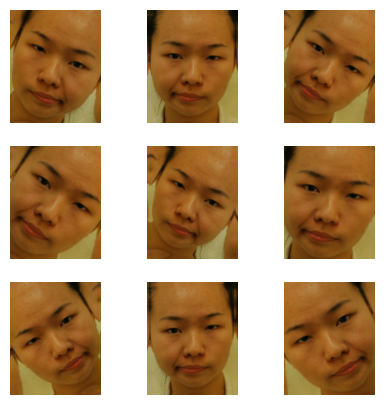

In [18]:
plt.figure(figsize=(5,5))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Here we use <code>prefetch</code> for caching and reducing RAM usage:

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Building the model

Determining model architecture

In [20]:
num_classes = len(class_names)

model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255, input_shape=(h,w, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, name="outputs")
])

Compiling the model:

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 200, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 200, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 80, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 80, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 40, 32)       0         
 2D)                                                  

Fitting the model:

(I defined an early stop callback so if there is no much proceed in 5 iterations, fitting will stop)

In [25]:
epochs=50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    tf.keras.callbacks.EarlyStopping(patience=5,verbose=2)
]

history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=callbacks,
  epochs=epochs
)

Epoch 1/50


8/8 [==============================] - 9s 1s/step - loss: 1.2651 - accuracy: 0.5242 - val_loss: 1.0921 - val_accuracy: 0.5772
Epoch 2/50
8/8 [==============================] - 8s 1s/step - loss: 1.1798 - accuracy: 0.5706 - val_loss: 1.0790 - val_accuracy: 0.6098
Epoch 3/50
8/8 [==============================] - 8s 1s/step - loss: 1.1366 - accuracy: 0.5746 - val_loss: 1.0760 - val_accuracy: 0.6179
Epoch 4/50
8/8 [==============================] - 8s 1s/step - loss: 1.0891 - accuracy: 0.5887 - val_loss: 0.9770 - val_accuracy: 0.6341
Epoch 5/50
8/8 [==============================] - 8s 1s/step - loss: 1.0513 - accuracy: 0.5786 - val_loss: 1.0436 - val_accuracy: 0.6098
Epoch 6/50
8/8 [==============================] - 8s 1s/step - loss: 1.0162 - accuracy: 0.6008 - val_loss: 1.0161 - val_accuracy: 0.6179
Epoch 7/50
8/8 [==============================] - 8s 1s/step - loss: 0.9892 - accuracy: 0.6190 - val_loss: 0.9324 - val_accuracy: 0.6341
Epoch 8/50
8/8 [==============================] - 8s

Early stopping has occurd after 40 epochs.

# Model Evaluation

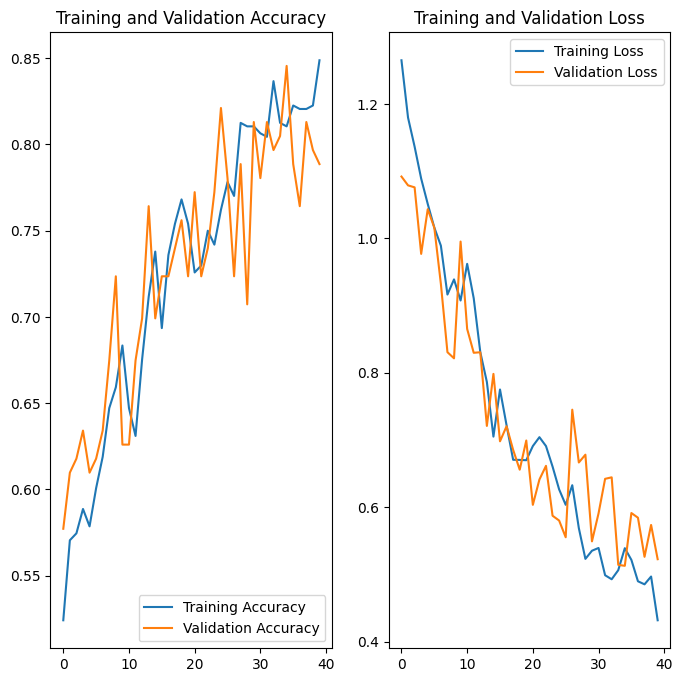

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Learning curves show excellent result for our learning model!

Now we load all the images in a variable 'X_train' and all the associated labels in variable 'y_train'.

Then we randomly choos a data, plot it and use the model to predict the label:

This image most likely belongs to happiness with a 93.65 percent confidence.


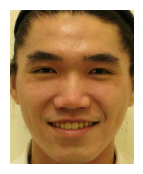

In [46]:
X_train = []
y_train = []

for images, labels in train_ds.map(lambda x, y: (x, y)):
    X_train.append(images)
    y_train.append(labels)

rand_batch_no = random.randint(0,batch_size)
X_rand = X_train[0][rand_batch_no].numpy()
ground_truth = y_train[0][rand_batch_no].numpy()
img_array = tf.expand_dims(X_rand, 0) # Create a batch

predictions = model(img_array).numpy()
y_pred = np.argmax(tf.nn.softmax(predictions).numpy())

score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

plt.figure(figsize=(2,2))
plt.imshow(X_rand.astype("uint8"))
plt.axis("off")
plt.show()

Music suggestion can now be simply done knowing the listener mood!